<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/KNN_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test validate splite

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.20,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [11]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [12]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [13]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [14]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [15]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(7, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


### ResNet

In [16]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [17]:
inp = Input(shape = (32,32,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [18]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])
"""
out = Dense(64,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)"""

"\nout = Dense(64,activation='relu')(out)\nout = Dropout(0.40)(out)\nout = Dense(128,activation='relu')(out)\nout = Dropout(0.45)(out)\nout = Dense(256,activation='relu')(out)\n#out = Dropout(0.50)(out)\n\n\noutput = Dense(8,activation='softmax')(out)"

In [19]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = out)

In [20]:
print("Feature extraction ...")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...
177/177 [==============================] - 8s 6ms/step


(5653, 480)

In [21]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [22]:
prediction_tes = np.array(e_model.predict([x_te,x_te]))

45/45 [==============================] - 0s 10ms/step


In [23]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [24]:
print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (5653, 480)
	Features testing shape:  (1414, 480)


### ROC for KNN

In [25]:
knn = KNeighborsClassifier()

In [26]:
error_rate = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(Xtrain,y_tr)
 pred_i = knn.predict(Xtest)
 error_rate.append(np.mean(pred_i != y_te))

Minimum error:- 0.13083451202263083 at K = 1


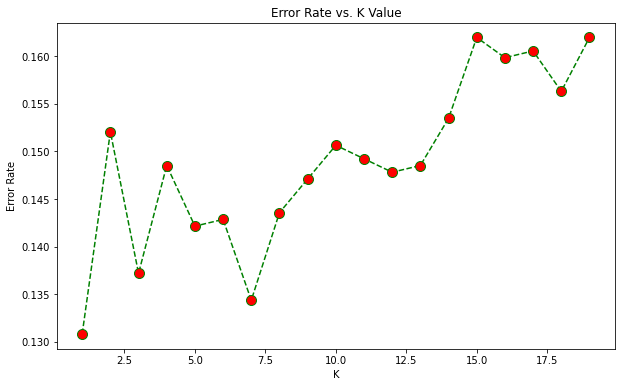

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='green', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

In [28]:
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

In [29]:
CV_knn = grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
CV_knn.fit(Xtrain, y_tr)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_neighbors=19),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy', verbose=1)

In [30]:
print(CV_knn.best_params_,CV_knn.best_score_)

{'n_neighbors': 1} 0.858834787244627


In [31]:
df = pd.DataFrame(CV_knn.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005504,0.000200,0.271826,0.014835,1,{'n_neighbors': 1},0.865782,0.851911,0.858811,0.858835,0.005663,1
1,0.005225,0.000220,0.306306,0.019409,2,{'n_neighbors': 2},0.840318,0.833333,0.850318,0.841323,0.006970,12
2,0.005358,0.000570,0.387531,0.089720,3,{'n_neighbors': 3},0.854111,0.853503,0.867834,0.858483,0.006617,2
3,0.006451,0.000680,0.510515,0.026372,4,{'n_neighbors': 4},0.842440,0.841295,0.858811,0.847515,0.008001,5
4,0.005929,0.000120,0.532593,0.020380,5,{'n_neighbors': 5},0.845093,0.847665,0.859342,0.850700,0.006200,4
5,0.006420,0.001262,0.416495,0.106032,6,{'n_neighbors': 6},0.839257,0.846072,0.847665,0.844331,0.003646,8
6,0.004749,0.000087,0.311126,0.004682,7,{'n_neighbors': 7},0.844032,0.850318,0.858280,0.850877,0.005830,3
7,0.004750,0.000012,0.309131,0.006806,8,{'n_neighbors': 8},0.833422,0.840234,0.851911,0.841855,0.007635,10
8,0.005070,0.000710,0.311245,0.006876,9,{'n_neighbors': 9},0.833422,0.843949,0.856157,0.844509,0.009290,7
9,0.004632,0.000096,0.321375,0.010728,10,{'n_neighbors': 10},0.831830,0.836518,0.852442,0.840263,0.008821,13


In [32]:
df = pd.DataFrame(CV_knn.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_n_neighbors','params','mean_test_score','rank_test_score']]

,param_n_neighbors,params,mean_test_score,rank_test_score
0,1,{'n_neighbors': 1},0.858835,1
2,3,{'n_neighbors': 3},0.858483,2
3,4,{'n_neighbors': 4},0.847515,5
4,5,{'n_neighbors': 5},0.850700,4
5,6,{'n_neighbors': 6},0.844331,8
6,7,{'n_neighbors': 7},0.850877,3
8,9,{'n_neighbors': 9},0.844509,7
10,11,{'n_neighbors': 11},0.844863,6
12,13,{'n_neighbors': 13},0.843447,9


In [40]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = KFold(n_splits=3)

In [41]:
knn=KNeighborsClassifier(n_neighbors=3)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    knn.fit(x_tr, y_trin)
    predicted_labels = knn.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = knn.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[   0    2    4 ... 5649 5651 5652] having : 3768
[   1    3    8 ... 5645 5648 5650] having : 1885
iteration 0
folds  1
[   1    2    3 ... 5649 5650 5651] having : 3769
[   0    4    7 ... 5643 5647 5652] having : 1884
iteration 1
folds  2
[   0    1    3 ... 5648 5650 5652] having : 3769
[   2    5    6 ... 5646 5649 5651] having : 1884
iteration 2


In [42]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

	Validation Accuracy of KNN: 0.8535


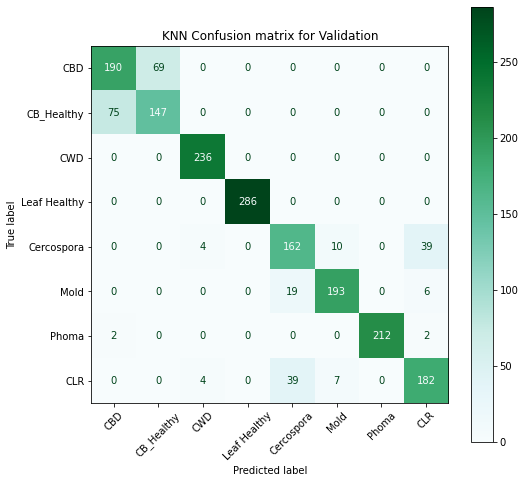

In [43]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Validation")
    plt.show()

	Training Accuracy of KNN: 0.9281


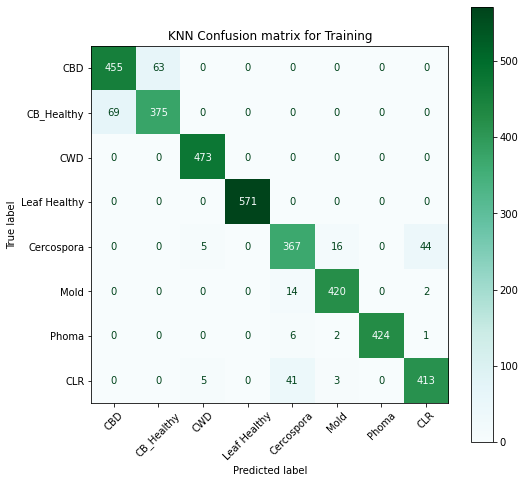

In [44]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of KNN: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Training")
    plt.show()

In [45]:
result = knn.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_te, order='C'))
print("\tTesting Accuracy of KNN: %0.4f" % acc)
print(classification_report(y_te,result,target_names=target_names))

	Testing Accuracy of KNN: 0.8621
              precision    recall  f1-score   support

         CBD       0.73      0.73      0.73       195
  CB_Healthy       0.69      0.70      0.69       166
         CWD       0.97      1.00      0.99       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.75      0.77      0.76       162
        Mold       0.93      0.95      0.94       164
       Phoma       1.00      0.96      0.98       162
         CLR       0.81      0.77      0.79       173

    accuracy                           0.86      1414
   macro avg       0.86      0.86      0.86      1414
weighted avg       0.86      0.86      0.86      1414



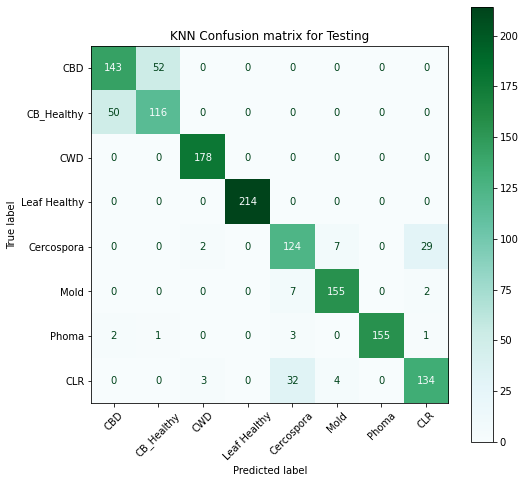

In [46]:
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("KNN Confusion matrix for Testing")
    plt.show()

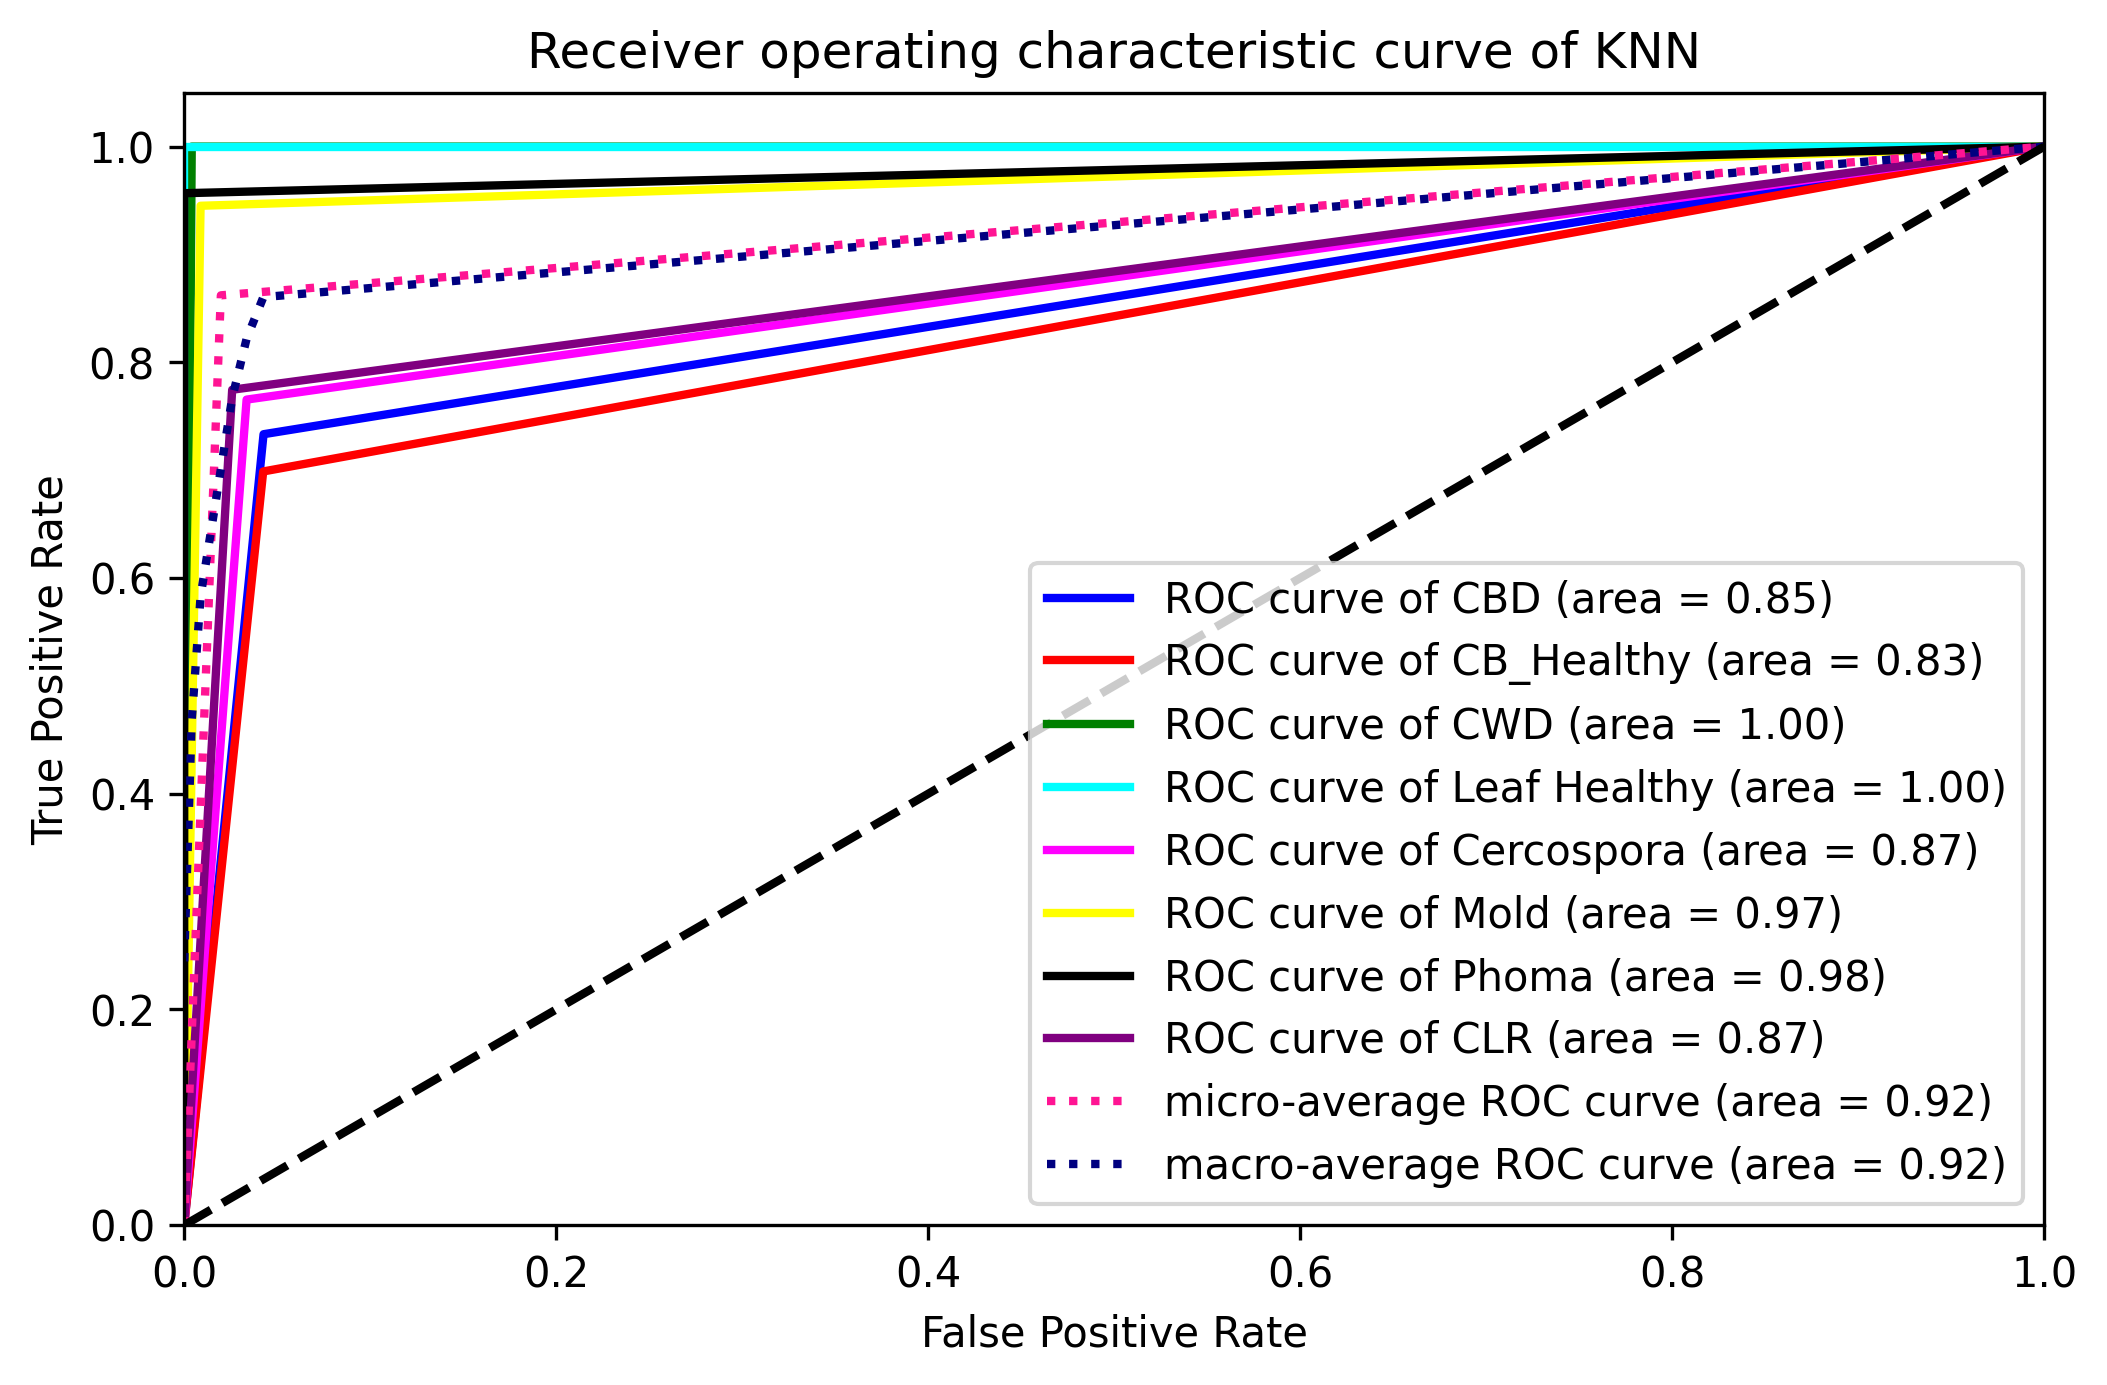

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Define class names
class_names = labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']

# Define number of classes
num_classes = len(class_names)

# Generate some example data
#y_true = np.array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7])
#y_score = np.random.rand(16, num_classes)  # Replace with your own prediction scores

# Binarize the labels
y_true = label_binarize(y_te, classes=np.arange(num_classes))
y_pre = label_binarize(result, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve
plt.figure(figsize=(8,5),dpi=300)
lw = 2
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle=':', label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=lw, linestyle=':', label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve of KNN')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix

In [ ]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD', 3 :'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

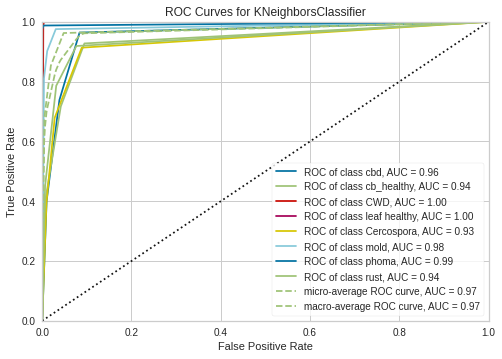

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7e059f8d0>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=KNeighborsClassifier(n_neighbors=3))

In [ ]:
plot_ROC_curve(knn,Xtrain,y_tr,Xtest,y_te)